In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import regex as re
import wranglerer as wr
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

In [2]:
cohort_df = wr.acquire_df()

local version found!


In [3]:
cohort_df.head()

,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,1,Arches,#arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1
1,2,Badlands,#badlands,2014-06-04,2014-08-22,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1
2,3,Carlsbad,#carlsbad,2014-09-04,2014-11-05,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1
3,4,Denali,#denali,2014-10-20,2015-01-18,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1
4,5,Everglades,#everglades,2014-11-18,2015-02-24,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1


In [4]:
df = pd.read_csv('anonymized-curriculum-access.txt',delimiter=' ',header=None)
column_names = ['date', 'time', 'page', 'user', 'cohort','ip']
df.columns =column_names

In [5]:
df['timestamp'] = df.date + ' ' + df.time

In [6]:
df_time = df

In [7]:
df = df.set_index('timestamp')
df = df.drop(columns=['date','time'])
df['user'] = df.user.astype('str')
df_time['user'] = df_time.user.astype('str')
df.cohort.fillna(777,inplace=True)
df_time.cohort.fillna(777,inplace=True)
df['cohort'] = df.cohort.astype('int').astype('str')
df_time['cohort'] = df_time.cohort.astype('int').astype('str')

In [8]:
df.cohort.astype('int').sort_values().unique()

array([  1,   2,   4,   5,   6,   7,   8,   9,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        31,  32,  33,  34,  51,  52,  53,  55,  56,  57,  58,  59,  61,
        62, 132, 133, 134, 135, 137, 138, 139, 777])

In [9]:
df.head()

,page,user,cohort,ip
timestamp,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61


## Page Count

In [10]:
page_df = pd.DataFrame(df.page.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'page', 'page': 'count'})
page_df2 = pd.DataFrame((df.page.value_counts(dropna=False))/df.page.count()).reset_index().\
                rename(columns={'index': 'page', 'page': 'proba'})
page_df = page_df.merge(page_df2, on='page')
page_df

,page,count,proba
0,/,50313,0.055890
1,search/search_index.json,19519,0.021682
2,javascript-i,18983,0.021087
3,toc,18297,0.020325
4,java-iii,13733,0.015255
...,...,...,...
2309,12-distributed-ml/6.1-prepare-part-1,1,0.000001
2310,12-distributed-ml/6.4-prepare-part-4,1,0.000001
2311,4-python,1,0.000001
2312,4-python/overview,1,0.000001


## User Count

In [11]:
user_df = pd.DataFrame(df.user.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'user', 'user': 'count'})
user_df2 = pd.DataFrame((df.user.value_counts(dropna=False))/df.user.count()).reset_index().\
                rename(columns={'index': 'user', 'user': 'proba'})
user_df = user_df.merge(user_df2, on='user')
user_df

,user,count,proba
0,11,17913,0.019898
1,64,16347,0.018159
2,53,12329,0.013695
3,314,7783,0.008646
4,1,7404,0.008225
...,...,...,...
976,66,1,0.000001
977,163,1,0.000001
978,918,1,0.000001
979,212,1,0.000001


## Cohort Count

In [12]:
cohort_df = pd.DataFrame(df.cohort.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'cohort', 'cohort': 'count'})
cohort_df2 = pd.DataFrame((df.cohort.value_counts(dropna=False))/df.cohort.count()).reset_index().\
                rename(columns={'index': 'cohort', 'cohort': 'proba'})
cohort_df = cohort_df.merge(cohort_df2, on='cohort')
cohort_df.head()

,cohort,count,proba
0,28,84031,0.093345
1,777,52893,0.058755
2,33,40730,0.045244
3,29,38096,0.042318
4,62,37109,0.041222


## IP Count

In [13]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'count'})
ip_df2 = pd.DataFrame((df.ip.value_counts(dropna=False))/df.ip.count()).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'proba'})
ip_df = ip_df.merge(ip_df2, on='ip')
ip_df.head()

,ip,count,proba
0,97.105.19.58,284579,0.316121
1,97.105.19.61,61662,0.068496
2,192.171.117.210,9515,0.010570
3,71.150.217.33,6791,0.007544
4,76.185.145.231,4754,0.005281


## Count Unique by Page

In [14]:
page_unq_df = df.groupby('page')[['user','ip','cohort']].nunique()

In [15]:
page_unq_df.sort_values('cohort',ascending=False)

,user,ip,cohort
page,,,
/,962,3366,48
search/search_index.json,701,1289,42
toc,656,1439,41
html-css,724,1205,41
javascript-i,725,1302,41
...,...,...,...
content/examples/examples/gitbook/images/favicon.ico,1,1,1
content/examples/examples/html,1,1,1
content/examples/examples/html/forms.html,1,1,1


In [16]:
page_unq_df.sort_values('cohort',ascending=False).head(10)

,user,ip,cohort
page,,,
/,962,3366,48
search/search_index.json,701,1289,42
toc,656,1439,41
html-css,724,1205,41
javascript-i,725,1302,41
java-i,634,1057,41
appendix,615,855,40
spring,612,1035,40
mysql,592,960,39


## Count Unique by User

In [17]:
user_unq_df = df.groupby('user')[['page','ip','cohort']].nunique()

In [18]:
user_unq_df.sort_values('cohort',ascending=False)

,page,ip,cohort
user,,,
88,197,33,4
64,437,34,4
346,190,25,3
663,46,3,3
644,158,1,2
...,...,...,...
405,13,1,1
406,33,6,1
407,160,8,1


## Count Unique by cohort

In [19]:
cohort_unq_df = df.groupby('cohort')[['page','ip','user']].nunique()

In [20]:
cohort_unq_df.sort_values('page',ascending=False)

,page,ip,user
cohort,,,
28,1404,318,51
777,1112,413,78
22,544,226,35
34,533,216,23
14,486,35,13
25,421,410,26
59,420,245,29
55,418,266,21
23,406,251,33


## Count Unique by IP

In [21]:
ip_unq_df = df.groupby('ip')[['page','user','cohort']].nunique()

In [22]:
ip_unq_df.sort_values('page',ascending=False)

,page,user,cohort
ip,,,
97.105.19.58,1315,402,28
192.171.117.210,555,306,32
76.185.131.226,437,2,3
97.105.19.61,421,128,12
76.185.145.231,336,1,1
...,...,...,...
187.237.231.85,1,1,1
187.237.231.72,1,1,1
187.201.77.208,1,1,1


In [23]:
df_time.head()

,date,time,page,user,cohort,ip,timestamp
0,2018-01-26,09:55:03,/,1,8,97.105.19.61,2018-01-26 09:55:03
1,2018-01-26,09:56:02,java-ii,1,8,97.105.19.61,2018-01-26 09:56:02
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,2018-01-26 09:56:05
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,2018-01-26 09:56:06
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61,2018-01-26 09:56:24


## Count Unique by date

In [24]:
date_unq_df = df_time.groupby('date')[['page','user','cohort']].nunique()

In [25]:
date_unq_df.sort_index()

,page,user,cohort
date,,,
2018-01-26,104,50,9
2018-01-27,86,18,4
2018-01-28,57,19,5
2018-01-29,98,61,9
2018-01-30,118,61,11
...,...,...,...
2021-04-17,162,65,15
2021-04-18,160,81,17
2021-04-19,242,174,20


## Count Unique by date USER 1

In [26]:
df_time[df_time['user'] == '1']

,date,time,page,user,cohort,ip,timestamp
0,2018-01-26,09:55:03,/,1,8,97.105.19.61,2018-01-26 09:55:03
1,2018-01-26,09:56:02,java-ii,1,8,97.105.19.61,2018-01-26 09:56:02
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,2018-01-26 09:56:05
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,2018-01-26 09:56:06
58,2018-01-26,10:40:15,javascript-i/functions,1,8,97.105.19.61,2018-01-26 10:40:15
...,...,...,...,...,...,...,...
899290,2021-04-21,09:13:54,python/dataframes,1,28,70.121.199.82,2021-04-21 09:13:54
899639,2021-04-21,10:32:19,/,1,28,70.121.199.82,2021-04-21 10:32:19
899640,2021-04-21,10:32:22,sql/mysql-overview,1,28,70.121.199.82,2021-04-21 10:32:22
899641,2021-04-21,10:32:29,python/dataframes,1,28,70.121.199.82,2021-04-21 10:32:29


In [27]:
date_unq_df2 = df_time[df_time['user'] == '333'].groupby('date')[['page']].nunique()

In [28]:
date_unq_df2.sort_index()

,page
date,
2019-01-22,16
2019-01-23,11
2019-01-24,7
2019-01-25,5
2019-01-28,11
...,...
2019-09-25,15
2019-11-20,12
2020-10-01,3


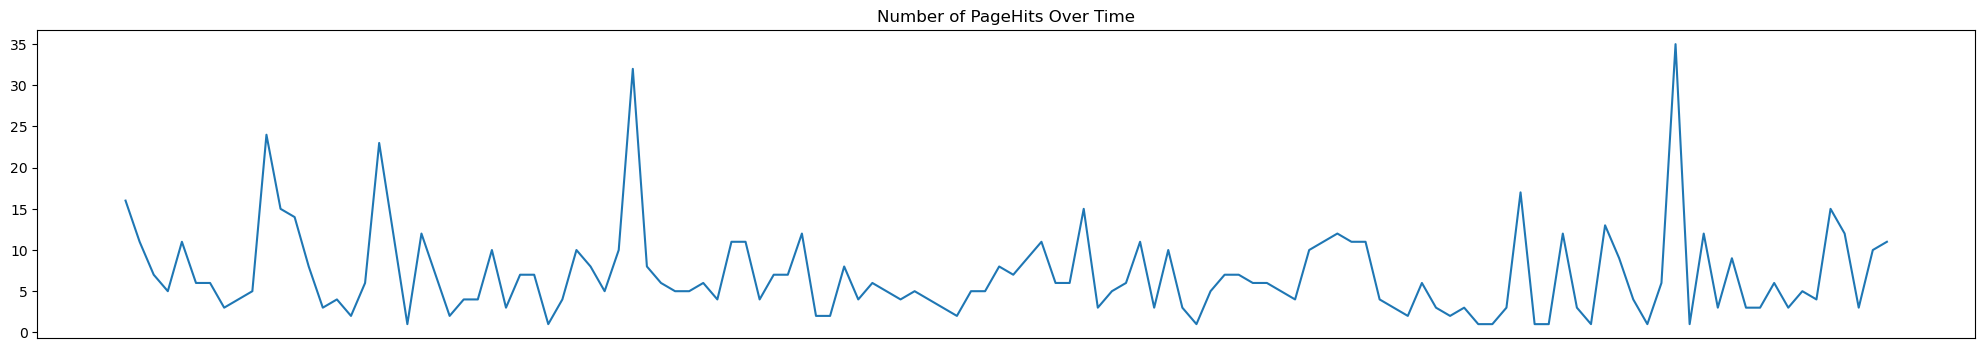

In [29]:
plt.figure(figsize=(25,4))
plt.plot(date_unq_df2)
plt.xticks([])
plt.title('Number of PageHits Over Time')
plt.show()

In [30]:
df_time[df_time['user'] == 333]

,date,time,page,user,cohort,ip,timestamp


In [31]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   date       900223 non-null  object
 1   time       900223 non-null  object
 2   page       900222 non-null  object
 3   user       900223 non-null  object
 4   cohort     900223 non-null  object
 5   ip         900223 non-null  object
 6   timestamp  900223 non-null  object
dtypes: object(7)
memory usage: 48.1+ MB


## first_access df 

In [32]:
df_time['user'] = df_time['user'].astype('int')
df_time['timestamp'] = pd.to_datetime(df_time['timestamp'])
df_time['date'] = df_time['timestamp'].dt.date

In [33]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       900223 non-null  object        
 1   time       900223 non-null  object        
 2   page       900222 non-null  object        
 3   user       900223 non-null  int64         
 4   cohort     900223 non-null  object        
 5   ip         900223 non-null  object        
 6   timestamp  900223 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 48.1+ MB


In [34]:
first_access = df_time.groupby('user').date.min()

In [35]:
first_access_date = pd.DataFrame({'date': first_access}).reset_index()

In [36]:
first_access_date

,user,date
0,1,2018-01-26
1,2,2018-01-26
2,3,2018-01-26
3,4,2018-01-26
4,5,2018-01-26
...,...,...
976,977,2021-04-12
977,978,2021-04-12
978,979,2021-04-12
979,980,2021-04-13


In [37]:
user_cnt_by_first_access_date = first_access_date.groupby(['date']).count().sort_index()

In [38]:
user_cnt_by_first_access_date.head()

,user
date,
2018-01-26,50
2018-01-27,2
2018-01-28,2
2018-01-29,12
2018-01-30,7


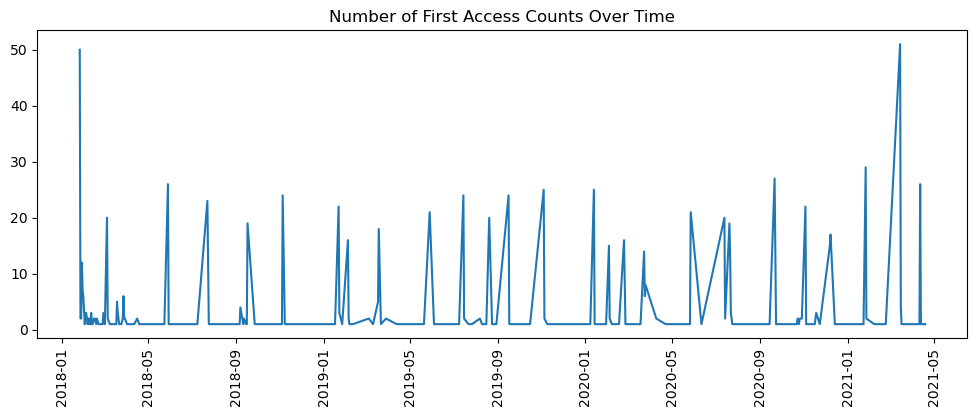

In [39]:
plt.figure(figsize=(12,4))
plt.plot(user_cnt_by_first_access_date)
plt.xticks(rotation=90)
plt.title('Number of First Access Counts Over Time')
plt.show()

#### 1 Which lesson appears to attract the most traffic consistently across cohorts

In [40]:
page_unq_df.sort_values('cohort',ascending=False).head(10)

,user,ip,cohort
page,,,
/,962,3366,48
search/search_index.json,701,1289,42
toc,656,1439,41
html-css,724,1205,41
javascript-i,725,1302,41
java-i,634,1057,41
appendix,615,855,40
spring,612,1035,40
mysql,592,960,39


#### html-css, javascript-i, java-i each have 41 cohorts ... "/", search_index, toc (table of contents) are not lessons

#### 2 IS there a cohort which referred to a lesson more than other cohorts

In [41]:
# Given a particular page, what is probability of a certain cohort
page_given_cohort = (
    df.groupby('cohort')\
    .page.value_counts(normalize=True)\
    .rename('proba_page_given_cohort')\
    .reset_index())
page_given_cohort

,cohort,page,proba_page_given_cohort
0,1,/,0.070416
1,1,javascript-i,0.033071
2,1,html-css,0.024184
3,1,javascript-ii,0.022947
4,1,spring,0.021597
...,...,...,...
14672,8,uploads/58a217a705bde.jpg,0.000584
14673,9,content/html-css,0.400000
14674,9,/,0.200000
14675,9,content/html-css/gitbook/images/favicon.ico,0.200000


In [42]:
page_given_cohort[page_given_cohort.proba_page_given_cohort < 1].sort_values('page')

,cohort,page,proba_page_given_cohort
11220,55,%20https://github.com/RaulCPena,0.000046
7915,28,',0.000012
11221,55,",%20https://github.com/RaulCPena",0.000046
5670,24,.git,0.000028
12470,59,.gitignore,0.000031
...,...,...,...
2053,137,where,0.000117
8185,28,working-with-time-series-data,0.000012
12335,59,working-with-time-series-data,0.000437
4979,22,wp-admin,0.000032


In [43]:
page_tot_by_cohort = page_given_cohort.groupby('cohort').nunique()

In [44]:
page_tot_by_cohort.head()

,page,proba_page_given_cohort
cohort,,
1,342,84
11,95,13
12,117,13
13,348,39
132,273,134


In [45]:
page_tot_by_cohort.sort_values('page',ascending=False).head(10)

,page,proba_page_given_cohort
cohort,,
28,1404,229
777,1112,207
22,544,148
34,533,137
14,486,86
25,421,129
59,420,148
55,418,133
23,406,151


#### cohort 22 referrenced 544 unique pages, cohort 34 referenced 533 unique pages and cohort 14 referenced 486 unique pages

#### 3 students who hardly access curriculum?

In [46]:
df.head()

,page,user,cohort,ip
timestamp,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61


In [47]:
df_time.head()

,date,time,page,user,cohort,ip,timestamp
0,2018-01-26,09:55:03,/,1,8,97.105.19.61,2018-01-26 09:55:03
1,2018-01-26,09:56:02,java-ii,1,8,97.105.19.61,2018-01-26 09:56:02
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,2018-01-26 09:56:05
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,2018-01-26 09:56:06
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61,2018-01-26 09:56:24


In [48]:
# grab the page count, grab the unique page access (per user)
page_views = df.groupby(['user'])['page'].agg(['count','nunique'])

In [49]:
page_views

,count,nunique
user,,
1,7404,976
10,922,144
100,59,20
101,224,86
102,80,48
...,...,...
979,127,20
98,91,48
980,3,1


In [50]:
page_views[(page_views['count'] < 50)]

,count,nunique
user,,
103,46,32
104,8,8
107,8,6
108,12,7
109,35,16
...,...,...
972,34,11
973,35,15
976,29,10


In [51]:
df0 = df_time.drop(columns=['time','timestamp'])
df0['date'] = pd.to_datetime(df0['date'])
df0 = df0.set_index('date')

In [52]:
df0.head()

,page,user,cohort,ip
date,,,,
2018-01-26,/,1,8,97.105.19.61
2018-01-26,java-ii,1,8,97.105.19.61
2018-01-26,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26,javascript-i/conditionals,2,22,97.105.19.61


In [53]:
df_resampled = df0.resample('D').page.count()

In [54]:
df_resampled.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: page, dtype: int64

In [55]:
ema_30 = df_resampled.ewm(span=30).mean()
std_30 = df_resampled.ewm(span=30).std()
upper_band = ema_30 + (3*std_30)
lower_band = ema_30 - (3*std_30)

In [58]:
bb_df = pd.concat([df_resampled,
                   ema_30,
                   upper_band,
                   lower_band], axis=1)
bb_df.columns = ['page_count',
                 'midband',
                 'ub',
                 'lb']

In [59]:
bb_df

,page_count,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116
...,...,...,...,...
2021-04-17,478,1325.179115,3545.216722,-894.858492
2021-04-18,659,1282.199817,3486.733695,-922.334061
2021-04-19,2156,1338.574023,3569.147958,-891.999913


In [60]:
bb_df['prcnt_b'] = (bb_df.page_count - bb_df.lb) / (
    bb_df['ub'] - bb_df['lb'])

In [61]:
bb_df

,page_count,midband,ub,lb,prcnt_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249
...,...,...,...,...,...
2021-04-17,478,1325.179115,3545.216722,-894.858492,0.309197
2021-04-18,659,1282.199817,3486.733695,-922.334061,0.358655
2021-04-19,2156,1338.574023,3569.147958,-891.999913,0.683232


In [62]:
def get_user(df,user):
    return df[df.user == user].resample('D').page.count()

In [66]:
def get_user_bb(user_df,user,span=30,k=3):
    ema = user_df.ewm(span=span).mean()
    std = user_df.ewm(span=span).std()
    upper_band = ema + k*std
    lower_band = ema - k*std
    bb_df = pd.concat([user_df,
                   ema,
                   upper_band,
                   lower_band], axis=1)
    bb_df.columns = ['page_count',
                 'midband',
                 'ub',
                 'lb']
    bb_df['prcnt_b'] = (bb_df.page_count - bb_df.lb) / (
    bb_df['ub'] - bb_df['lb'])
    bb_df['user_id'] = user
    return bb_df

In [67]:
bb_df = get_user_bb(get_user(df0,user=1),user=1)

In [68]:
bb_df

,page_count,midband,ub,lb,prcnt_b,user_id
date,,,,,,
2018-01-26,7,7.000000,NaN,NaN,NaN,1
2018-01-27,1,3.900000,16.627922,-8.827922,0.386077,1
2018-01-28,0,2.512403,13.712115,-8.687309,0.387836,1
2018-01-29,6,3.473363,13.961213,-7.014487,0.620455,1
2018-01-30,5,3.820710,13.002533,-5.361113,0.564219,1
...,...,...,...,...,...,...
2021-04-17,0,8.666278,47.796135,-30.463580,0.389263,1
2021-04-18,8,8.623292,46.473148,-29.226564,0.491766,1
2021-04-19,10,8.712112,45.335193,-27.910969,0.517583,1


In [71]:
def get_anomalies(df,user,k=3,span=30):
    user_df=get_user(df,user)
    bb_df = get_user_bb(user_df,user,span=span,k=k)
    anomalies = bb_df[bb_df.prcnt_b >= 1]
    return anomalies

In [72]:
get_anomalies(df0,1)

,page_count,midband,ub,lb,prcnt_b,user_id
date,,,,,,
2018-02-20,54,6.456745,50.349000,-37.435509,1.041590,1
2018-05-29,68,9.612443,62.374629,-43.149742,1.053309,1
2018-11-07,13,1.221442,11.524503,-9.081619,1.071605,1
2018-12-19,25,2.880262,22.002760,-16.242235,1.078369,1
2019-01-29,44,3.623334,36.587343,-29.340675,1.112436,1
2019-07-08,101,8.248768,83.899086,-67.401549,1.113026,1
2020-01-15,41,6.259332,39.731193,-27.212529,1.018953,1
2021-01-05,40,4.050795,35.348264,-27.246673,1.074315,1
2021-04-15,52,9.075259,50.177299,-32.026781,1.022173,1


In [79]:
for i in range(1,982):
    print(get_anomalies(df0,i))

            page_count   midband         ub         lb   prcnt_b  user_id
date                                                                     
2018-02-20          54  6.456745  50.349000 -37.435509  1.041590        1
2018-05-29          68  9.612443  62.374629 -43.149742  1.053309        1
2018-11-07          13  1.221442  11.524503  -9.081619  1.071605        1
2018-12-19          25  2.880262  22.002760 -16.242235  1.078369        1
2019-01-29          44  3.623334  36.587343 -29.340675  1.112436        1
2019-07-08         101  8.248768  83.899086 -67.401549  1.113026        1
2020-01-15          41  6.259332  39.731193 -27.212529  1.018953        1
2021-01-05          40  4.050795  35.348264 -27.246673  1.074315        1
2021-04-15          52  9.075259  50.177299 -32.026781  1.022173        1
Empty DataFrame
Columns: [page_count, midband, ub, lb, prcnt_b, user_id]
Index: []
            page_count   midband        ub        lb   prcnt_b  user_id
date                           

            page_count   midband         ub         lb   prcnt_b  user_id
date                                                                     
2018-04-05          20  1.514175  17.319073 -14.290723  1.084813       80
2018-05-15          10  0.749473   9.319511  -7.820566  1.039702       80
2018-07-19          11  0.724015   9.033131  -7.585100  1.118356       80
2018-08-20          19  1.311493  15.788226 -13.165239  1.110929       80
2018-10-28           6  0.491085   5.985317  -5.003148  1.001336       80
2018-11-07          13  1.090779  11.438839  -9.257281  1.075433       80
2018-12-25          19  1.378659  15.800658 -13.043340  1.110919       80
2019-01-12          27  3.126326  25.066248 -18.813596  1.044069       80
2019-04-01          27  1.775898  22.134301 -18.582505  1.119501       80
2019-06-05          34  2.727600  29.073415 -23.618215  1.093498       80
2019-08-22           7  0.466631   6.088774  -5.155512  1.081039       80
2019-08-23          13  1.275235  12.1

            page_count   midband         ub         lb   prcnt_b  user_id
date                                                                     
2018-11-29           4  0.258199   3.259841  -2.743442  1.123292      179
2019-04-08           7  0.451657   5.699047  -4.795733  1.123962      179
2019-05-21           7  0.477280   5.861008  -4.906449  1.105781      179
2019-08-07          20  1.292950  16.288748 -13.702847  1.123743      179
2019-09-01          34  2.437604  28.599315 -23.724107  1.103217      179
2019-10-14          22  1.585313  19.224780 -16.054155  1.078665      179
2020-01-29           4  0.259659   3.301423  -2.782105  1.114831      179
2020-06-07           7  0.451657   5.699051  -4.795736  1.123961      179
2020-10-06          10  0.645303   8.141900  -6.851295  1.123930      179
            page_count   midband        ub         lb   prcnt_b  user_id
date                                                                    
2018-07-02          48  4.203658  41.969

            page_count   midband         ub         lb   prcnt_b  user_id
date                                                                     
2019-04-16          17  1.215583  14.497275 -12.066109  1.094217      273
2019-09-17           3  0.193638   2.444949  -2.057672  1.123273      273
2021-01-08          32  2.064516  26.052026 -21.922994  1.123981      273
            page_count    midband          ub         lb   prcnt_b  user_id
date                                                                       
2018-11-08         108  19.732229  100.669607 -61.205149  1.045284      274
2019-06-17           7   0.753164    6.948473  -5.442145  1.004159      274
2019-08-14          27   1.757675   22.007007 -18.491657  1.123288      274
2019-12-19           3   0.194764    2.467767  -2.078239  1.117077      274
            page_count   midband         ub         lb   prcnt_b  user_id
date                                                                     
2019-04-30           4  0.

            page_count   midband         ub         lb   prcnt_b  user_id
date                                                                     
2019-08-10          22  1.996414  19.204552 -15.211724  1.081225      368
2019-08-13          45  4.537639  40.557885 -31.482606  1.061661      368
2019-09-05          35  3.541161  34.291096 -27.208775  1.011527      368
2019-11-11          15  1.239457  13.230566 -10.751652  1.073781      368
2020-04-10           1  0.084497   0.944305  -0.775311  1.032388      368
2020-04-14           3  0.318615   2.693454  -2.056224  1.064540      368
            page_count   midband         ub         lb   prcnt_b  user_id
date                                                                     
2019-04-25          24  3.841716  23.377333 -15.693901  1.015937      369
2019-10-28           3  0.208460   2.477962  -2.061042  1.115012      369
2019-11-01           7  0.724182   6.283599  -4.835235  1.064431      369
2019-11-04          25  2.205770  21.1

            page_count   midband         ub         lb   prcnt_b  user_id
date                                                                     
2020-03-17           3  0.193549   2.442393  -2.055295  1.123976      465
2020-05-15           6  0.390881   4.897233  -4.115471  1.122357      465
2020-05-28          44  3.002964  35.988787 -29.982859  1.121434      465
2020-07-20          32  2.166608  26.784604 -22.451388  1.105927      465
2020-12-08           1  0.064805   0.851070  -0.721460  1.094707      465
            page_count   midband         ub         lb   prcnt_b  user_id
date                                                                     
2020-01-19          38  5.682520  37.061676 -25.696637  1.014951      466
2020-06-24           7  0.452299   5.706346  -4.801748  1.123110      466
2020-08-07           7  0.475658   5.851066  -4.899750  1.106869      466
2020-09-10          12  0.853367  10.005537  -8.298803  1.108961      466
2020-09-22          15  1.578115  14.4

            page_count   midband         ub         lb   prcnt_b  user_id
date                                                                     
2020-07-07          66  5.249867  55.027681 -44.527947  1.110213      556
            page_count   midband         ub         lb   prcnt_b  user_id
date                                                                     
2020-07-24          24  1.801208  20.000678 -16.398261  1.109875      557
            page_count   midband         ub         lb   prcnt_b  user_id
date                                                                     
2020-07-15          24  2.960294  23.096364 -17.175775  1.022438      558
            page_count   midband        ub        lb   prcnt_b  user_id
date                                                                   
2020-08-30           8  0.624204  7.152862 -5.904453  1.064878      559
2020-09-21           9  0.724567  8.102245 -6.653112  1.060843      559
2020-10-06           9  0.923184  8.964208 -7.

            page_count   midband        ub        lb   prcnt_b  user_id
date                                                                   
2020-06-25           3  0.205795  2.512281 -2.100690  1.105728      650
2020-08-09           3  0.264750  2.653746 -2.124246  1.072469      650
2020-09-30           1  0.072761  0.938415 -0.792894  1.035571      650
2021-02-12           5  0.322590  4.070644 -3.425465  1.123978      650
            page_count   midband         ub         lb   prcnt_b  user_id
date                                                                     
2020-12-08           9  0.580646   7.327137  -6.165845  1.123980      651
2021-01-17          19  1.385499  15.757842 -12.986843  1.112792      651
Empty DataFrame
Columns: [page_count, midband, ub, lb, prcnt_b, user_id]
Index: []
            page_count   midband        ub        lb   prcnt_b  user_id
date                                                                   
2020-08-27           3  0.251331  2.852423 -2

            page_count    midband         ub         lb   prcnt_b  user_id
date                                                                      
2020-11-27          70  13.413613  69.417414 -42.590188  1.005201      748
            page_count   midband         ub         lb   prcnt_b  user_id
date                                                                     
2021-01-11          32  4.749104  31.049417 -21.551208  1.018072      749
2021-02-01          55  8.000206  51.381085 -35.380674  1.041711      749
2021-03-01          49  6.315205  47.515395 -34.884985  1.018017      749
2021-04-05          38  4.038429  35.448625 -27.371767  1.040614      749
            page_count    midband         ub         lb   prcnt_b  user_id
date                                                                      
2020-10-26          56   8.729161  54.486542 -37.028220  1.016538      750
2021-02-01         101  11.357678  88.052472 -65.337116  1.084409      750
            page_count    midba

            page_count  midband         ub         lb   prcnt_b  user_id
date                                                                    
2021-02-17          27  4.92504  26.038935 -16.188855  1.022759      848
Empty DataFrame
Columns: [page_count, midband, ub, lb, prcnt_b, user_id]
Index: []
Empty DataFrame
Columns: [page_count, midband, ub, lb, prcnt_b, user_id]
Index: []
            page_count   midband         ub         lb   prcnt_b  user_id
date                                                                     
2021-02-23          67  8.229409  58.023833 -41.565015  1.090132      851
Empty DataFrame
Columns: [page_count, midband, ub, lb, prcnt_b, user_id]
Index: []
Empty DataFrame
Columns: [page_count, midband, ub, lb, prcnt_b, user_id]
Index: []
            page_count   midband         ub         lb   prcnt_b  user_id
date                                                                     
2021-04-06          19  1.348943  15.670031 -12.972146  1.116261      854
     

Empty DataFrame
Columns: [page_count, midband, ub, lb, prcnt_b, user_id]
Index: []
Empty DataFrame
Columns: [page_count, midband, ub, lb, prcnt_b, user_id]
Index: []
Empty DataFrame
Columns: [page_count, midband, ub, lb, prcnt_b, user_id]
Index: []
Empty DataFrame
Columns: [page_count, midband, ub, lb, prcnt_b, user_id]
Index: []
Empty DataFrame
Columns: [page_count, midband, ub, lb, prcnt_b, user_id]
Index: []
Empty DataFrame
Columns: [page_count, midband, ub, lb, prcnt_b, user_id]
Index: []
Empty DataFrame
Columns: [page_count, midband, ub, lb, prcnt_b, user_id]
Index: []
Empty DataFrame
Columns: [page_count, midband, ub, lb, prcnt_b, user_id]
Index: []
Empty DataFrame
Columns: [page_count, midband, ub, lb, prcnt_b, user_id]
Index: []
Empty DataFrame
Columns: [page_count, midband, ub, lb, prcnt_b, user_id]
Index: []
Empty DataFrame
Columns: [page_count, midband, ub, lb, prcnt_b, user_id]
Index: []
Empty DataFrame
Columns: [page_count, midband, ub, lb, prcnt_b, user_id]
Index: []
Empt

In [80]:
anom1 = pd.DataFrame(get_anomalies(df0,1))

In [81]:
anom1

,page_count,midband,ub,lb,prcnt_b,user_id
date,,,,,,
2018-02-20,54,6.456745,50.349000,-37.435509,1.041590,1
2018-05-29,68,9.612443,62.374629,-43.149742,1.053309,1
2018-11-07,13,1.221442,11.524503,-9.081619,1.071605,1
2018-12-19,25,2.880262,22.002760,-16.242235,1.078369,1
2019-01-29,44,3.623334,36.587343,-29.340675,1.112436,1
2019-07-08,101,8.248768,83.899086,-67.401549,1.113026,1
2020-01-15,41,6.259332,39.731193,-27.212529,1.018953,1
2021-01-05,40,4.050795,35.348264,-27.246673,1.074315,1
2021-04-15,52,9.075259,50.177299,-32.026781,1.022173,1


In [82]:
anom3 = pd.DataFrame(get_anomalies(df0,3))

In [83]:
anom3

,page_count,midband,ub,lb,prcnt_b,user_id
date,,,,,,
2018-10-15,9,0.581421,7.332272,-6.169430,1.123520,3
2019-01-09,4,0.262470,3.296452,-2.771512,1.115945,3
2019-04-06,2,0.129825,1.638299,-1.378649,1.119890,3


In [84]:
anom1 = pd.concat([anom1,
                   anom3], axis=0)

In [85]:
anom1

,page_count,midband,ub,lb,prcnt_b,user_id
date,,,,,,
2018-02-20,54,6.456745,50.349000,-37.435509,1.041590,1
2018-05-29,68,9.612443,62.374629,-43.149742,1.053309,1
2018-11-07,13,1.221442,11.524503,-9.081619,1.071605,1
2018-12-19,25,2.880262,22.002760,-16.242235,1.078369,1
2019-01-29,44,3.623334,36.587343,-29.340675,1.112436,1
2019-07-08,101,8.248768,83.899086,-67.401549,1.113026,1
2020-01-15,41,6.259332,39.731193,-27.212529,1.018953,1
2021-01-05,40,4.050795,35.348264,-27.246673,1.074315,1
2021-04-15,52,9.075259,50.177299,-32.026781,1.022173,1


In [111]:
anom = pd.DataFrame(columns=['page_count', 'midband', 'ub', 'lb','prcnt_b','user_id'])

for i in range(1,982):
    temp_df = pd.DataFrame(get_anomalies(df0,i))
    anom = pd.concat([anom,temp_df],axis=0)
    #anom = anom.append(temp_df,ignore_index=True)

In [119]:
anom[anom['page_count'] > 200].sort_values('page_count',ascending=False)

,page_count,midband,ub,lb,prcnt_b,user_id
2020-07-22,285,44.915959,266.290617,-176.458698,1.042257,11
2019-03-03,272,24.721632,232.200343,-182.757078,1.095913,341
2020-04-16,271,44.194413,267.834945,-179.446120,1.007076,570
2019-07-25,253,34.698961,222.709718,-153.311796,1.080555,422
2020-04-05,232,32.133967,205.731770,-141.463837,1.075658,570
2018-12-19,225,20.831494,216.533997,-174.871009,1.021630,313


In [117]:
anom[anom['user_id'] == 570]

,page_count,midband,ub,lb,prcnt_b,user_id
2020-04-05,232,32.133967,205.731770,-141.463837,1.075658,570
2020-04-16,271,44.194413,267.834945,-179.446120,1.007076,570
2020-08-10,66,7.040462,60.216039,-46.135116,1.054385,570
2021-02-08,3,0.195577,2.464699,-2.073546,1.117953,570
2021-02-11,53,3.579468,43.234126,-36.075191,1.123137,570
